In [8]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
import analysis_kit as ak
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def squareit(n):
    return n*n

In [3]:
squareit(5)

25

In [4]:
widgets.interact(squareit, n=(0,100))

interactive(children=(IntSlider(value=50, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.squareit>

### ------------------------------------------------------------------------------------------------------------------------------------------------------

### GBM interactive plots

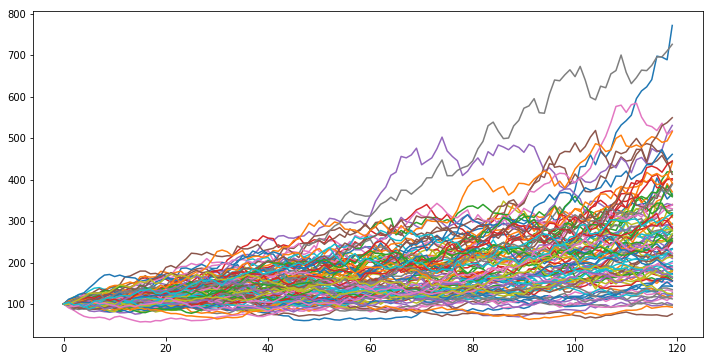

In [17]:
ak.gbm(10,100, 0.1).plot(figsize=(12,6), legend=False) # As you can see, this is a static plot

#### If you would like to interactively understand how changeing the mu affects the return distribution, use ipywidgets

In [40]:
# So, lets first write a function

def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion Model
    """
    s_0=100
    prices=ak.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax=prices.plot(legend=False, figsize=(12,6), color="indianred",alpha=0.5, linewidth=2) # alpha is the transparency of the line
    ax.axhline(y=s_0, ls=":", color="black")
    ax.set_ylim(top=400) # Fixes the maximum value of y-axis to 400
    
    # draw a dot at origin
    
    ax.plot(0,s_0, marker="o",color="darkred", alpha=0.2)
    ax.margins(x=0)

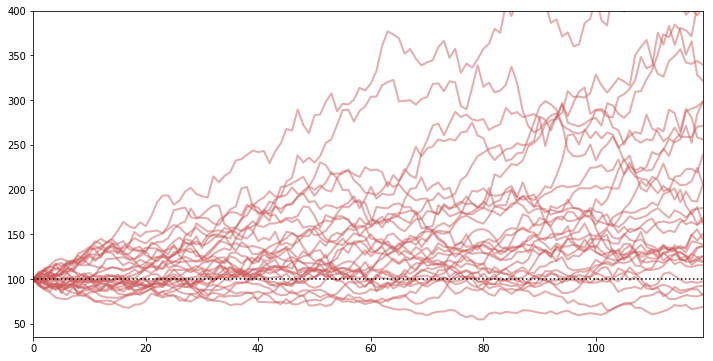

In [41]:
show_gbm(30, 0.07, 0.15)

#### Interactive time

In [42]:
gbm_controls=widgets.interactive(show_gbm,
                                n_scenarios=(1,20,1), ## creating a tuple which as min, max and step size
                                mu= (-0.20,0.2,0.01),
                                sigma=(0,0.3,0.01)
                                ) 

In [43]:
display(gbm_controls)

interactive(children=(IntSlider(value=10, description='n_scenarios', max=20, min=1), FloatSlider(value=0.0, description='mu', max=0.2, min=-0.2, step=0.01), FloatSlider(value=0.15, description='sigma', max=0.3, step=0.01), Output()), _dom_classes=('widget-interact',))

### Interactive CPPI Simulation- Monte Carlo

In [ ]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0.,rf_rate=0.03, y_max=100):
    """
    Plot the results of Monte Carlo Simulation of CPPI
    """
    
    start=100
    sim_rets=ak.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, steps_per_year=12, )